In [ ]:
import pandas as pd
import numpy as np


df_path =  '/home/agusitn/Documents/projects/blue-dollar-ml/data/processed/info_finally.csv'
df = pd.read_csv(df_path, parse_dates=['fecha'], index_col='fecha')
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
print(len(df))

df['returns'] = df['dolar_blue'].pct_change()

lags = [1,2,3,4,5,10]

for l in lags:
    df[f"lag_{l}"] = df['returns'].shift(l)
print(df.columns)

""" 
Creamos una linea de tendecias en base 5/10/20 dias si la media esperada (rolling_mean ) es positiva y alta
significa que la tendecia del el ultimo mes/semana/dias es que el dolar suba.

Luego si la desviacion estandar es muy volatil quiere decir que el dolar baja y sube constantemente... es decir: 
Si la desviacion estandar (rolling_std) es alta el dolar un dia puede subir un 5% y al otro un 20% y de repente al otro baja un 19%
Si la desviacion estandar es baja el mercado esta estable
"""
windows = [5,10,20]
for w in windows:
    df[f'rolling_mean_{w}'] = df['returns'].rolling(window=w).mean()
    df[f'rolling_std_{w}'] = df['returns'].rolling(window=w).std()

# print(len(df))
# df.dropna(inplace=True)
# print(len(df))
df.to_csv('/home/agusitn/Documents/projects/blue-dollar-ml/data/processed/feature_basic.csv')

print(len(df))

2094


KeyError: 'valor'

In [5]:
import pandas as pd
import numpy as np

def get_rsi(series_data, periodo=14):
    # series_data is already the price column. Compute directly.
    delta = series_data.diff()
    delta = delta.dropna() # Diff creates a NaN at the beginning

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # We use ewm (exponential weighted moving)
    avg_gain = gain.ewm(com=periodo-1, adjust=False).mean()
    avg_loss = loss.ewm(com=periodo-1, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_path = '/home/agusitn/Documents/projects/blue-dollar-ml/data/processed/dollar_official-dollar_blue.csv'

df = pd.read_csv(df_path)

df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df.dropna(subset=['fecha'], inplace=True)

df.drop_duplicates(subset=['fecha'], keep='first', inplace=True)

df.set_index('fecha', inplace=True)

df['valor'] = pd.to_numeric(df['dolar_blue'], errors='coerce')
df.dropna(subset=['valor'], inplace=True) # Drop rows if any fetch failed


print("Calculando RSI...")
df['rsi'] = get_rsi(df['valor'], periodo=14)

print("Calculando Fechas...")
df['day_of_week'] = df.index.dayofweek
df['is_end_of_month'] = (df.index.day > 25).astype(int)

print("calculamos la brecha entre el blue y el oficial...")
df['brecha'] = (df['dolar_blue'] - df['dolar_oficial']) / df['dolar_oficial']

# Final cleaning (RSI leaves the first 14 days empty)
df.dropna(inplace=True)


save_path = '/home/agusitn/Documents/projects/blue-dollar-ml/data/processed/features_advanced.csv'
df.to_csv(save_path)

print("¡Listo! Archivo features_advanced.csv creado sin errores.")

Calculando RSI...
Calculando Fechas...
calculamos la brecha entre el blue y el oficial...
¡Listo! Archivo features_advanced.csv creado sin errores.


In [ ]:
import pandas as pd

source_path = "/home/agusitn/Documents/projects/blue-dollar-ml/data/raw/tipos-de-cambio-historicos.csv"

df = pd.read_csv(source_path, parse_dates=["fecha"], index_col="fecha")
df = df.sort_index()

df = df.loc["2017-01-01":, ["dolar_estadounidense"]]
df.to_csv(
    "/home/agusitn/Documents/projects/blue-dollar-ml/data/processed/official-dollar.csv",
    index=True
)
print(df.index)
print(df.columns)


DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2025-11-21', '2025-11-22', '2025-11-23', '2025-11-24',
               '2025-11-25', '2025-11-26', '2025-11-27', '2025-11-28',
               '2025-11-29', '2025-11-30'],
              dtype='datetime64[ns]', name='fecha', length=3256, freq=None)
Index(['dolar_estadounidense'], dtype='object')


In [ ]:
"""Creamos el nuevo modelo"""

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import pandas as pd 
# 1. Load
df = pd.read_csv(df_path, parse_dates=['fecha'], index_col='fecha')

df['retorno_blue'] = df['valor'].pct_change()
df['retorno_oficial'] = df['dolar_oficial'].pct_change()

cols_a_desplazar = ['rsi', 'brecha', 'retorno_blue', 'retorno_oficial'] 

cols_existentes = [c for c in cols_a_desplazar if c in df.columns]
df[cols_existentes] = df[cols_existentes].shift(1)

df['target_return'] = df['valor'].pct_change()
df['target_up'] = (df['target_return'] > 0).astype(int)

# 4. Cleaning
df.dropna(inplace=True)

# 5. Define features
features = []
# Blacklist of columns that CANNOT enter the model
columnas_prohibidas = [
    'returns', 'target_up', 'target_return', 'valor', 
    'dolar_blue', 'dolar_oficial', # <--- DO NOT USE RAW PRICES
    'fecha'
]

for col in df.columns:
    if col not in columnas_prohibidas:
        features.append(col)

print(f"Entrenando con: {features}")

x = df[features]
y = df['target_up']

total_lines = len(df)
# print(total_lines)
data_train = int(total_lines * 0.70)
# print(data_train)
data_validation = int(total_lines * 0.85)

x_train = x.iloc[:data_train]
y_train = y.iloc[:data_train]

x_validation = x.iloc[data_train:data_validation]
y_validation = y.iloc[data_train:data_validation]

x_test = x.iloc[data_validation:]
y_test = y.iloc[data_validation:]

""" Escalo los valores por buena practica nomas ya que el modelo de 
Random forest no me lo pide, porque solo hace preguntas de "si o no" """

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_validation_scaled = scaler.transform(x_validation)
x_test_scaled = scaler.transform(x_test)

model_random_forest = RandomForestClassifier(n_estimators=100, min_samples_split=20, random_state=42)
model_random_forest.fit(x_train_scaled, y_train)

predict = model_random_forest.predict(x_test_scaled)
accuracy = accuracy_score(y_test, predict)

print("\nResultados del Gran Desafío:")
print(f"Modelo con Features Avanzados: {accuracy:.2%}")
print(f"Baseline a vencer (Como Ayer): 58.68%")

if accuracy > 0.5868:
    print("¡OBJETIVO CUMPLIDO! Tu modelo aprendió patrones reales.")
else:
    print("Seguimos empatados o perdiendo. Necesitamos modelos más complejos.")


Entrenando con: ['rsi', 'day_of_week', 'is_end_of_month', 'brecha', 'retorno_blue', 'retorno_oficial']

Resultados del Gran Desafío:
Modelo con Features Avanzados: 66.56%
Baseline a vencer (Como Ayer): 58.68%
¡OBJETIVO CUMPLIDO! Tu modelo aprendió patrones reales.


 Entrenando con: ['rsi', 'day_of_week', 'is_end_of_month', 'brecha', 'retorno_blue', 'retorno_oficial']
 Simulando inversión...


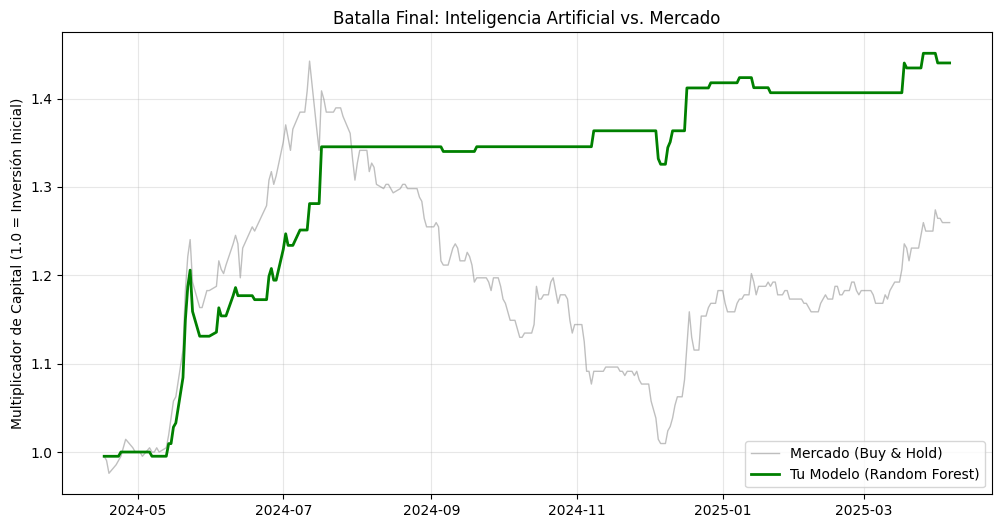


--- RESULTADOS FINALES ---
 Mercado (Buy & Hold): 25.96%
 Tu Estrategia IA:     44.02%
 ¡GANASTE! Tu modelo superó al mercado por 18.06 puntos porcentuales.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# --- 1. DATA PREPARATION (THE 68% LOGIC) ---
df_path = '/home/agusitn/Documents/projects/blue-dollar-ml/data/processed/features_advanced.csv'
df = pd.read_csv(df_path, parse_dates=['fecha'], index_col='fecha')

# A. Transform prices to percentages (key against inflation)
df['retorno_blue'] = df['valor'].pct_change()
df['retorno_oficial'] = df['dolar_oficial'].pct_change()

# B. Shift to avoid seeing the future
# Shift technical indicators and returns from YESTERDAY
cols_a_desplazar = ['rsi', 'brecha', 'retorno_blue', 'retorno_oficial'] 
# Verify they exist before shifting
cols_existentes = [c for c in cols_a_desplazar if c in df.columns]
df[cols_existentes] = df[cols_existentes].shift(1)

# C. Define the target
# We want to predict TODAY's return
df['target_return'] = df['valor'].pct_change()
df['target_up'] = (df['target_return'] > 0).astype(int)

# D. Cleaning
df.dropna(inplace=True)

# E. Feature selection (raw prices are forbidden)
features = []
columnas_prohibidas = ['returns', 'target_up', 'target_return', 'valor', 'dolar_blue', 'dolar_oficial']

for col in df.columns:
    if col not in columnas_prohibidas:
        features.append(col)

print(f" Entrenando con: {features}")

# --- 2. SPLIT THE TIMELINE ---
X = df[features]
y = df['target_up']
real_returns = df['target_return'] # Store real returns to compute money

total_rows = len(df)
train_idx = int(total_rows * 0.85) # Leave the last 15% for the simulation

X_train, X_test = X.iloc[:train_idx], X.iloc[train_idx:]
y_train, y_test = y.iloc[:train_idx], y.iloc[train_idx:]
test_returns = real_returns.iloc[train_idx:] # Returns for the test period

# --- 3. TRAINING (WINNING MODEL) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, min_samples_split=20, random_state=42)
rf.fit(X_train_scaled, y_train)

# --- 4. MONEY SIMULATION (BACKTESTING) ---
print(" Simulando inversión...")
predicciones = rf.predict(X_test_scaled)

# Logic:
# If it predicts 1 (Up) -> Buy/Hold (earn whatever the market moves)
# If it predicts 0 (Down) -> Sell/Stay in pesos (0% return in USD)
# (Note: this assumes zero transaction costs for simplicity)
strategy_returns = test_returns * predicciones

# Compound interest calculation (cumulative)
# Start with base 1 (100% of your capital)
cumulative_market = (1 + test_returns).cumprod()
cumulative_strategy = (1 + strategy_returns).cumprod()

# --- 5. FINAL CHART ---
plt.figure(figsize=(12, 6))

# Gray line: the market (buy & hold)
plt.plot(cumulative_market, label='Mercado (Buy & Hold)', color='gray', alpha=0.5, linewidth=1)

# Green line: your ML strategy
plt.plot(cumulative_strategy, label='Tu Modelo (Random Forest)', color='green', linewidth=2)

plt.title('Batalla Final: Inteligencia Artificial vs. Mercado')
plt.ylabel('Multiplicador de Capital (1.0 = Inversión Inicial)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Results in numbers
total_market = (cumulative_market.iloc[-1] - 1) * 100
total_strategy = (cumulative_strategy.iloc[-1] - 1) * 100

print(f"\n--- RESULTADOS FINALES ---")
print(f" Mercado (Buy & Hold): {total_market:.2f}%")
print(f" Tu Estrategia IA:     {total_strategy:.2f}%")

if total_strategy > total_market:
    diff = total_strategy - total_market
    print(f" ¡GANASTE! Tu modelo superó al mercado por {diff:.2f} puntos porcentuales.")
else:
    print(" El modelo es conservador. Ganó menos, pero quizás arriesgó menos.")